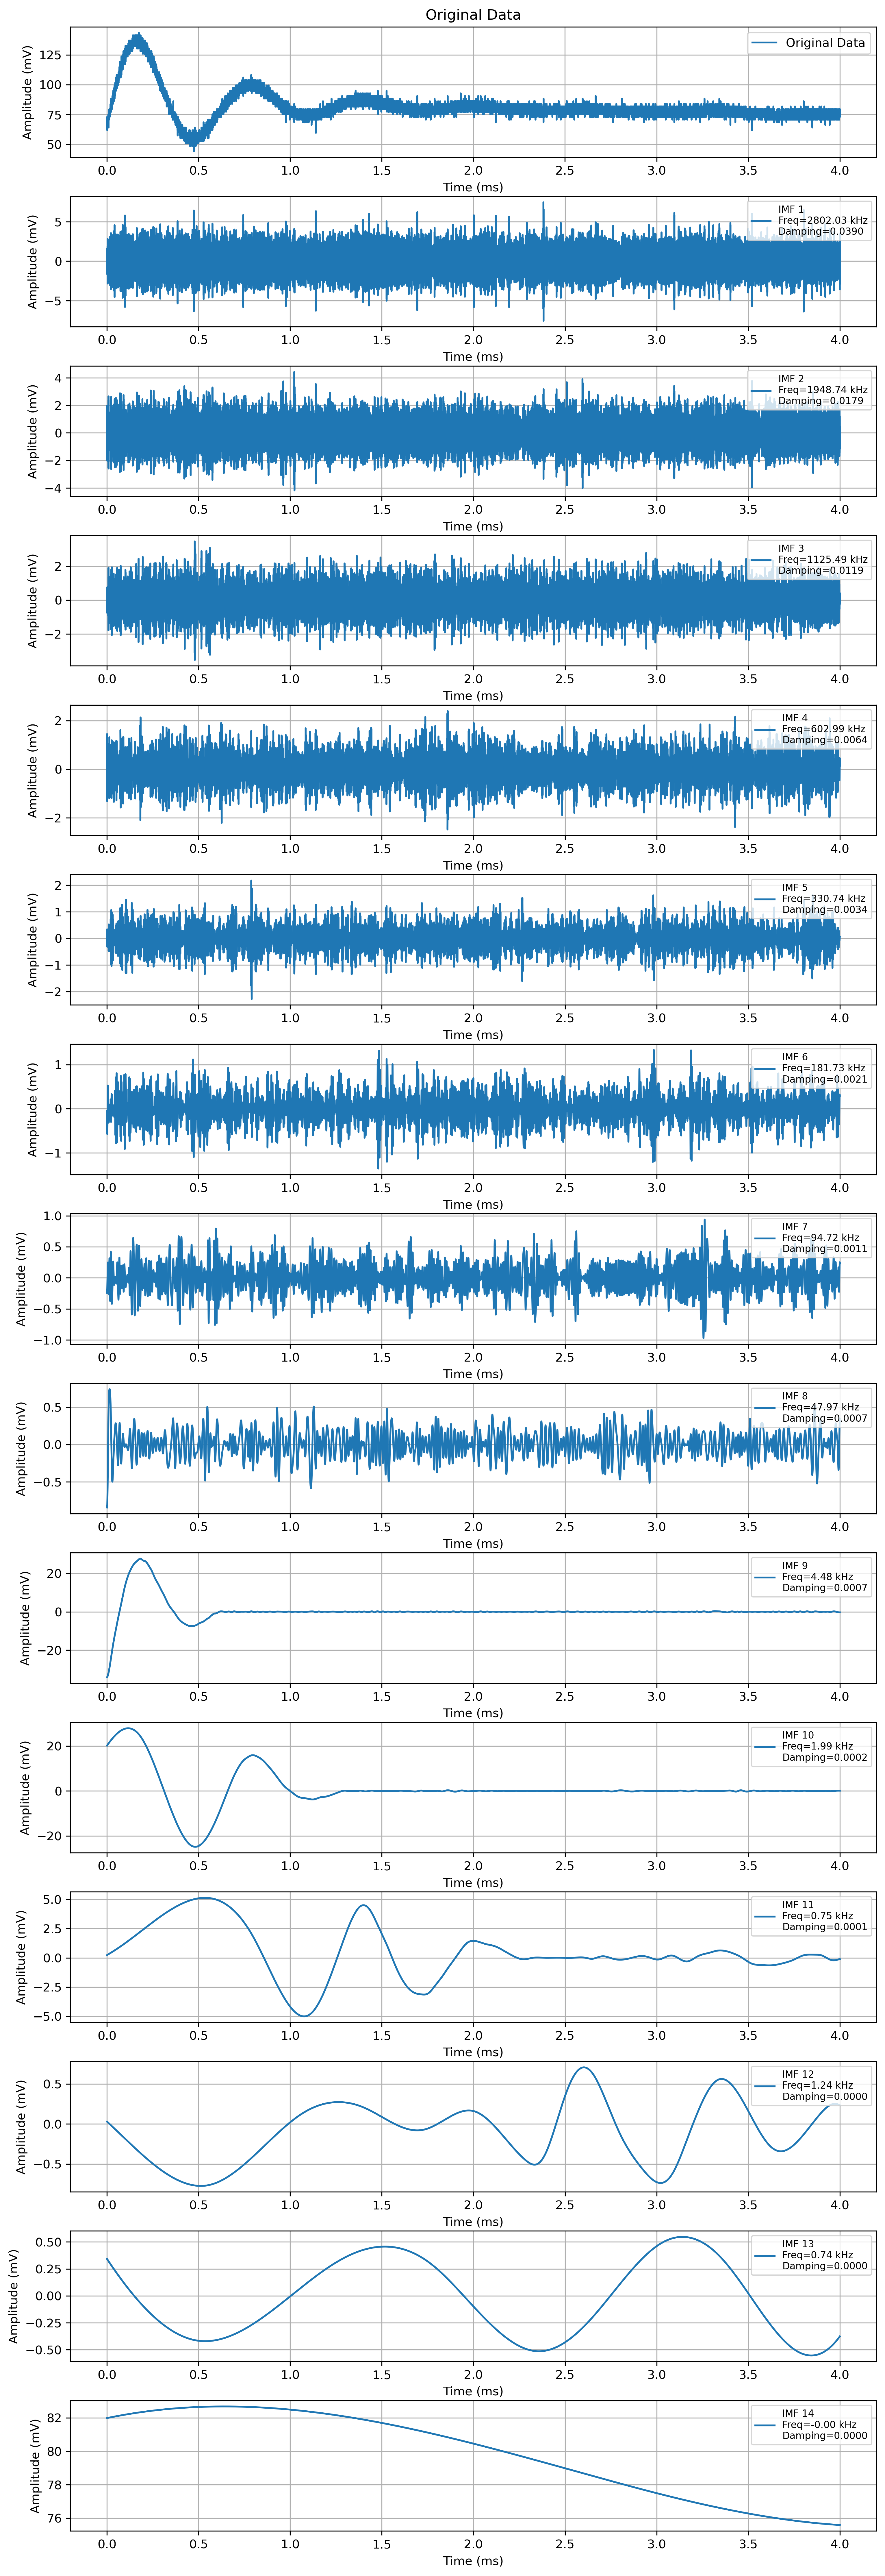

In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 데이터 불러오기
file_path = 'C1Trace00001.csv'
data = pd.read_csv(file_path)
data.columns = ['Time', 'Voltage']

# 음수 시간 데이터 제거
filtered_data = data[data['Time'] >= 0].reset_index(drop=True)
time = filtered_data['Time'].to_numpy()
voltage_mV = filtered_data['Voltage'].to_numpy() * 1000  # 밀리볼트 변환
time_ms = time * 1000  # 밀리초 변환

# 4ms 구간으로 데이터 자르기
cut_off_time = 4
valid_indices = time_ms <= cut_off_time
time_ms = time_ms[valid_indices]
voltage_mV = voltage_mV[valid_indices]

# EMD 수행
emd = EMD()
imfs = emd.emd(voltage_mV)

# 그래프 설정
num_plots = len(imfs) + 1
fig, axes = plt.subplots(num_plots, 1, figsize=(12, min(2.5 * num_plots, 200)), dpi=300)

# 오리지널 데이터 플롯
axes[0].plot(time_ms, voltage_mV, label='Original Data')
axes[0].legend(loc='upper right')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True)

# IMF 데이터 플롯
for i, imf in enumerate(imfs):
    analytic_signal = hilbert(imf)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency_kHz = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(time_ms / 1000)) / 1000  # kHz 변환
    damping_ratio = np.mean(np.abs(np.diff(np.log(amplitude_envelope + 1e-10)))) / (2 * np.pi)

    axes[i + 1].plot(time_ms[:-1], imf[:-1], label=f'IMF {i+1}\nFreq={np.mean(instantaneous_frequency_kHz):.2f} kHz\nDamping={damping_ratio:.4f}')
    axes[i + 1].legend(loc='upper right', fontsize=8)
    axes[i + 1].set_xlabel('Time (ms)')
    axes[i + 1].set_ylabel('Amplitude (mV)')
    axes[i + 1].grid(True)

plt.subplots_adjust(hspace=0.3)
plt.show()


추정된 감쇠비: 0.0500
추정된 고유 주파수 (rad/s): 314.1593


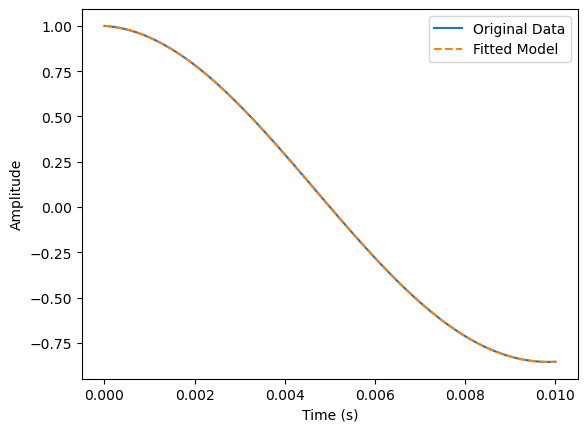

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 데이터 생성 (예시)
time = np.linspace(0, 0.01, 100)  # 10ms 이내의 한 주기 이하 데이터
true_zeta = 0.05  # 실제 감쇠비
true_freq = 50  # 실제 주파수 (Hz)
omega = 2 * np.pi * true_freq
signal = np.exp(-true_zeta * omega * time) * np.cos(omega * time)

# 감쇠 모델 함수 정의
def damped_cosine(t, A, zeta, omega, phi):
    return A * np.exp(-zeta * omega * t) * np.cos(omega * t + phi)

# 비선형 피팅
popt, _ = curve_fit(damped_cosine, time, signal, p0=[1, 0.01, omega, 0])

# 피팅된 파라미터 출력
A_fit, zeta_fit, omega_fit, phi_fit = popt
print(f"추정된 감쇠비: {zeta_fit:.4f}")
print(f"추정된 고유 주파수 (rad/s): {omega_fit:.4f}")

# 결과 시각화
plt.plot(time, signal, label='Original Data')
plt.plot(time, damped_cosine(time, *popt), label='Fitted Model', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

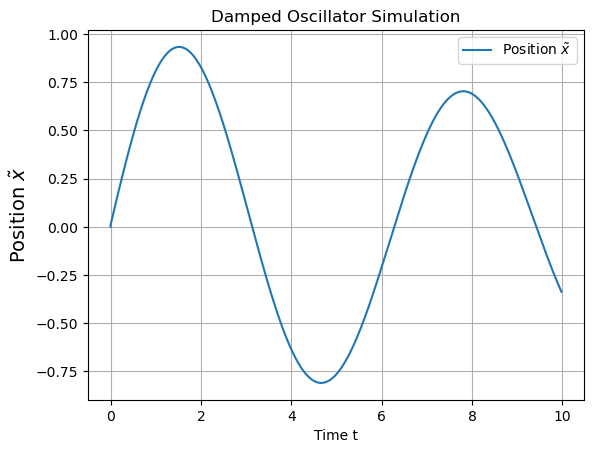

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 시스템 조건 설정
dt = 1.e-2  # 시간 스텝
gam = 0.1   # 감쇠 계수
imax = 1000 # 최대 반복 횟수 (시간 스텝 수)

# 초기 조건 설정
t = 0.0
x = 0.0
y = 1.0

# 결과 저장을 위한 배열
t_values = np.zeros(imax)
x_values = np.zeros(imax)

# 시스템 통합 (시뮬레이션 진행)
for i in range(imax):
    t_values[i] = t
    x_values[i] = x
    dx = y
    dy = -gam * y - x
    x = x + dx * dt
    y = y + dy * dt
    t = i * dt

# 결과 시각화
plt.plot(t_values, x_values, label=r"Position $\tilde{x}$")
plt.xlabel('Time t')
#plt.ylabel('Position x')
#plt.ylabel('', r"Position $\tilde{x}$")
plt.ylabel(r"Position $\tilde{x}$",fontsize=14)

plt.title('Damped Oscillator Simulation')
plt.grid(True)
plt.legend()
plt.show()
